In [85]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit

In [36]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [37]:
mapper = JordanWignerMapper()

In [38]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-0.80718366 * IIII
+0.17374013 * IIIZ
-0.23047453 * IIZI
+0.12148839 * IIZZ
+0.17374013 * IZII
+0.16940471 * IZIZ
+0.16658220 * IZZI
+0.04509381 * XXXX
+0.04509381 * XXYY
+0.04509381 * YYXX
+0.04509381 * YYYY
-0.23047453 * ZIII
+0.16658220 * ZIIZ
+0.17510657 * ZIZI
+0.12148839 * ZZII


In [240]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2


seed = 70
algorithm_globals.random_seed = seed

device = GenericBackendV2(num_qubits=4, seed=seed)
noise_model = NoiseModel.from_backend(device)
# noise_model.add_all_qubit_quantum_error()
print(noise_model)

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed}
)

# noisy x = 0.99X + 0.01I

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'x', 'measure', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('cx', (0, 1)), ('cx', (1, 0)), ('cx', (0, 2)), ('cx', (2, 0)), ('cx', (0, 3)), ('cx', (3, 0)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 3)), ('cx', (3, 2)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,))]


In [242]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe_solver = VQE(noiseless_estimator, ansatz, L_BFGS_B())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

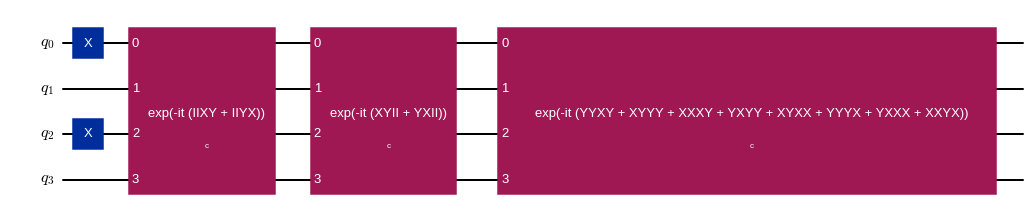

In [215]:
circuit = QuantumCircuit(4)
circuit.compose(ansatz.initial_state, inplace=True)
for block in ansatz._entanglement_blocks:
  circuit.compose(block, inplace=True)
circuit.draw(output="mpl")

In [229]:
for excitation in ansatz._excitation_list:
    print(f"{excitation[0]} => {excitation[1]}")

(0,) => (1,)
(2,) => (3,)
(0, 2) => (1, 3)


In [248]:
ansatz.operators

[SparsePauliOp(['IIXY', 'IIYX'],
               coeffs=[ 0.5+0.j, -0.5+0.j]),
 SparsePauliOp(['XYII', 'YXII'],
               coeffs=[ 0.5+0.j, -0.5+0.j]),
 SparsePauliOp(['YYXY', 'XYYY', 'XXXY', 'YXYY', 'XYXX', 'YYYX', 'YXXX', 'XXYX'],
               coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
   0.125+0.j,  0.125+0.j])]

In [230]:
# from qiskit_nature.second_q.problems import EigenstateResult
# 
# raw_result = (vqe_solver.compute_minimum_eigenvalue(qubit_op))
# res = es_problem.interpret(EigenstateResult.from_result(raw_result))

In [243]:
calc = GroundStateEigensolver(mapper, vqe_solver)
res = calc.solve(es_problem)
# print(res)

In [244]:
calculated = res.eigenvalues[0] + res._nuclear_repulsion_energy
actual = res._hartree_fock_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", res._hartree_fock_energy)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -0.6117336766016851
Actual Energy: -0.6148699740425608
Percentage Error: -0.51%


In [245]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    res = calc.solve(es_problem)
    vqe_energies.append(res.eigenvalues[0] + res._nuclear_repulsion_energy)

Calculating energies: 100%|██████████| 37/37 [00:04<00:00,  7.73it/s]


In [246]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

interpolated_function = interp1d(distances, vqe_energies, kind='cubic')
result = minimize_scalar(interpolated_function, bounds=(distances.min(), distances.max()), method='bounded')

min_distance = result.x
min_energy = result.fun
print(f"The distance that minimizes the energy is: {min_distance} Å")
print(f"The minimum energy is: {min_energy} Hartree")
# -0.98 hartree minimum energy for noisy
# -1.11 for noiseless

The distance that minimizes the energy is: 0.7120002236312097 Å
The minimum energy is: -1.115751881753092 Hartree


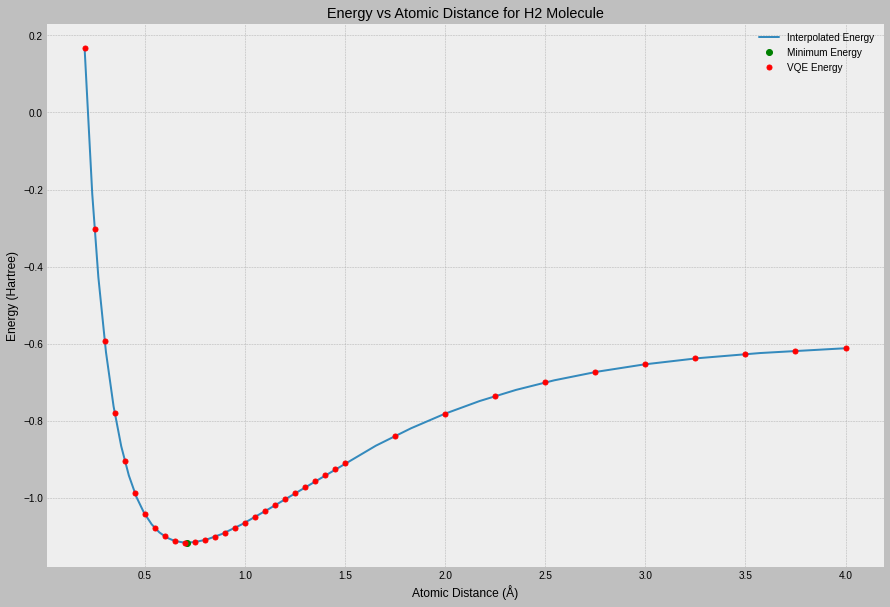

In [247]:
fine_distances = np.linspace(distances.min(), distances.max(), 500)
interpolated_energies = interpolated_function(fine_distances)
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(fine_distances, interpolated_energies, label='Interpolated Energy')
plt.plot(min_distance, min_energy, 'go', label='Minimum Energy')
plt.plot(distances, vqe_energies, marker='o', color='red', linestyle='', markersize=5, label='VQE Energy')
plt.xlabel('Atomic Distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy vs Atomic Distance for H2 Molecule')
plt.grid(True)
plt.legend()
plt.show()